In [1]:
################################################################################
# File name:    "closest_boundary_matches_mtlines.ipynb"
#
# Project title:    Boston Affordable Housing project (visting scholar porject)
#
# Description:    Takes the final closest boundary match set and determines if
#                 the property falls along a straight line section of the 
#                 boundary. The procedure follows (Turner 20xx), hence why this 
#                 is labeled mtlines. Properties are identified as along 
#                 straight lines if the 2 end points of a line 100 meters long 
#                 and orthogonal to the the shortest line from the property 
#                 to the boundary, with middle point on this line, are 15 meters 
#                 or less from the boundary.
#
# Inputs:    ./closest_boundary_matches.dta
#            ./adm3.shp
#
# Outputs:    ./closest_boundary_mtlines.csv    
#             ./closest_boundary_mtlines_log.txt
#
# Created:    10/12/2022
# Updated:    10/26/2022
#
# Author:    Nicholas Chiumenti
################################################################################

In [2]:
import os
import re
import shutil
import numpy as np
import pandas as pd
import geopandas as gpd
from datetime import datetime
from shapely.geometry import Point, LineString
from shapely.ops import nearest_points
import matplotlib.pyplot as plt

In [3]:
start_time = datetime.now()
print("Running closest_boundary_mtlines program...")

Running closest_boundary_mtlines program...


# Import data

In [4]:
# import property data
data_path = "/home/a1nfc04/Documents/boston_zoning_sdrive/data/closest_boundary_matches/closest_boundary_matches_with_regs.dta"

data_df = pd.read_stata(data_path)

# check observation count
assert len(data_df) == 579242, "incorrect number of observatons in data_df"

# define as a geodataframe w/ crs=4269
data_gdf = gpd.GeoDataFrame(data_df, geometry = gpd.points_from_xy(data_df["warren_longitude"], data_df["warren_latitude"],),
                            crs = "EPSG:4269")

# convert crs to 26986 for measuring in emters
data_gdf.to_crs("EPSG:26986", inplace=True)

print("Done loading property data!")

Done loading property data!


In [5]:
# import boundary data
boundary_path = "/home/a1nfc04/Documents/boston_zoning_sdrive/data/shapefiles/zoning_boundaries/adm3_crs26986/adm3.shp"

boundary_gdf = gpd.read_file(boundary_path)

# check observation count and crs
assert len(boundary_gdf) == 36151, "incorrect number of observations in boundary_gdf"
assert boundary_gdf.crs == 26986, "boundary_gdf has incorrect crs"

# create a static unique id
boundary_gdf["unique_id"] = boundary_gdf.index

# trim unnessecary fields from boundary_gdf
boundary_gdf = boundary_gdf[["unique_id", "geometry"]].copy()

print("Done loading boundary shape file!")

Done loading boundary shape file!


# Merge address points to boundary lines

In [6]:
# merge based on unique id and boundary using id
merged_df = data_gdf.merge(boundary_gdf, 
                           how = "left", 
                           left_on = "boundary_using_id", 
                           right_on = "unique_id", 
                           suffixes = ('_point', '_line'),
                           indicator = True,
                           validate = "m:1")

# check that it was done correctly
assert len(merged_df) == 579242, "incorrect number of observations in merged_df"
assert dict(merged_df["_merge"].value_counts()) == {'both': 579242, 'left_only': 0, 'right_only': 0}, "incorrect merge results"

# drop _merge variable
merged_df.drop(columns = "_merge", inplace = True)

print("Done merging property and boundary data!")

Done merging property and boundary data!


# Calculate orthogonal line and identify straight lines

In [7]:
print("Calculating straight line matches...")

# set counter to zero
n = 0

# set orthogonal line length (meters)
ORTH_LEN_M = 100 # set meter length for the orthogonal line

# set straight line distance length (meters)
STRA_LEN_M = 15

# iterate through every row to identify straight lines
for i, row in merged_df.iterrows():
    
    # increment count by 1
    n+=1
    
    # assign property point and boundar line
    address_point = row["geometry_point"]
    boundary_line = row["geometry_line"]

    # calculate nearest point from property on boundary line
    nearest_x, nearest_y = nearest_points(address_point, boundary_line)
    
    # create a line from property to nearest point on boundary line
    nearest_line = LineString([nearest_x, nearest_y])

    # get left/right parallel line half the distance of ORTH_LEN_M
    left_par_line = nearest_line.parallel_offset(ORTH_LEN_M / 2, "left")
    right_par_line = nearest_line.parallel_offset(ORTH_LEN_M / 2, "right")

    # store end points that are on/closest to the boundary line
    left_point = left_par_line.boundary[1]
    right_point = right_par_line.boundary[0]

    # calculate nearest distance from end points to boundary line
    left_dist_m = left_point.distance(boundary_line)
    right_dist_m = right_point.distance(boundary_line)

    # store distance in merged_df
    merged_df.loc[i, "left_dist_m"] = round(left_dist_m, 3)
    merged_df.loc[i, "right_dist_m"] = round(right_dist_m, 3)
    
    print(f"Working on {n:,} of {len(merged_df):,} observations...", end="\r")
    
# tag straight line matches with dummy variable
mask = ((merged_df["left_dist_m"] <= STRA_LEN_M) 
        & (merged_df["right_dist_m"] <= STRA_LEN_M))

merged_df["straight_line"] = 0
merged_df.loc[mask, "straight_line"] = 1

# drop geometry variables
merged_df.drop(columns = ["geometry_point", "geometry_line", "unique_id"], inplace = True)

# confirm straight line id counts
assert dict(merged_df["straight_line"].value_counts()) == {0: 448337, 1: 130905}, f"incorrect number of straight line observatins =1"

print("Done calcualting straight line matches!")

Calculating straight line matches...
Done calcualting straight line matches!ons...


# Error checks

In [9]:
# check prop_id
assert dict(merged_df["prop_id"].describe()) == {"count": 579242.0,
                                                 "mean": 1530088.854727385,
                                                 "std": 1482415.603575112,
                                                 "min": 28314.0,
                                                 "25%": 416751.25,
                                                 "50%": 1001160.0,
                                                 "75%": 2004267.75,
                                                 "max": 5068039.0}, "incorrect sum stats for prop_id"

# check straight_line
assert dict(merged_df["straight_line"].describe()) == {"count": 579242.0, 
                                                       "mean": 0.2259936261527997, 
                                                       "std": 0.41823535129362666, 
                                                       "min": 0.0, 
                                                       "25%": 0.0, 
                                                       "50%": 0.0, 
                                                       "75%": 0.0, 
                                                       "max": 1.0}, "in correct sum stats for straight_line"

# check straight line ids
assert dict(merged_df[merged_df["straight_line"]==1]["prop_id"].describe()) == {"count": 130905.0, 
                                                                                "mean": 1553506.9343722546, 
                                                                                "std": 1509358.2142772397, 
                                                                                "min": 28314.0, 
                                                                                "25%": 407300.0, 
                                                                                "50%": 1109376.0, 
                                                                                "75%": 2025544.0, 
                                                                                "max": 5068039.0}, "incorrect sum stats for prop_id if straight_line==1"

print("Done checking for errors!")

Done checking for errors!


# Export data and save log

In [10]:
# save final_df for export
final_df = merged_df.copy()

# set save and log paths
log_path = "/home/a1nfc04/Documents/boston_zoning_sdrive/python_programs/closest_boundary_matches/closest_boundary_matches_mtlines_log.txt"

# save data paths
save_file = "closest_boundary_matches_mtlines.csv"
save_folder = "/home/a1nfc04/Documents/boston_zoning_sdrive/data/closest_boundary_matches"
save_path = os.path.join(save_folder, save_file)

# subdir for old exports
old_saves_folder = "/home/a1nfc04/Documents/boston_zoning_sdrive/data/closest_boundary_matches/old_export_versions"

# check if current save version exists, if so then move it to the old versions folder
contents = [item for item in os.listdir(save_folder)]
if save_file in contents:

    # create previous saves folder is doesn't exist
    if os.path.isdir(old_saves_folder) == False:
        os.makedirs(old_saves_folder)
    
    # move file to sub-directory
    old_file_path = os.path.join(old_saves_folder, save_file)
    shutil.move(save_path, old_file_path)
    
    # rename the old file with creation date
    create_date = datetime.fromtimestamp(os.path.getmtime(old_file_path)).strftime("_%Y-%m-%d")
    new_file_name = os.path.splitext(old_file_path)[0] + create_date + ".csv"   
    os.rename(old_file_path, new_file_name)

# create log and save date stamps
end_time = datetime.now()

duration = end_time - start_time

duration_in_s = (duration.days * 24 * 60 * 60) + duration.seconds
mins, secs = divmod(duration_in_s, 60)
hours, mins = divmod(mins, 60)
days, hours  = divmod(hours, 24)

# save dataset as .csv
final_df.to_csv(save_path, index = False)

# write to log
with open(log_path,'a') as file:
    file.write(f"Last run on {datetime.now().strftime('%D at %I:%M:%S %p')}\n")
    file.write(f"{len(final_df):,} observations written to {save_path} \n")
    file.write(f"Total run time: {days} days, {hours:02} hours, {mins:02} minutes, {secs:02} seconds \n\n")

# Done!
print(f"Done, {len(final_df):,} observations written!")

Done, 579,242 observations written!


In [11]:
# fig, ax = plt.subplots()
# ax.set_aspect('equal')

# boundary_line = gpd.GeoSeries(boundary_line, crs="EPSG:26986")
# nearest_point = gpd.GeoSeries(nearest_point, crs="EPSG:26986")
# address_point = gpd.GeoSeries(address_point, crs="EPSG:26986")
# left_par_line = gpd.GeoSeries(left_par_line, crs="EPSG:26986")
# right_par_line = gpd.GeoSeries(right_par_line, crs="EPSG:26986")
# left_point = gpd.GeoSeries(left_point, crs="EPSG:26986")
# right_point = gpd.GeoSeries(right_point, crs="EPSG:26986")
# cd = gpd.GeoSeries(cd, crs="EPSG:26986")

# boundary_line.plot(ax=ax, color="blue")
# nearest_point.plot(ax=ax, color="blue")
# address_point.plot(ax=ax, color="blue")
# left_par_line.plot(ax=ax, color="yellow")
# right_par_line.plot(ax=ax, color="purple")
# left_point.plot(ax=ax, color="yellow")
# right_point.plot(ax=ax, color="purple")
# cd.plot(ax=ax, color="red")
# plt.show()

In [39]:
# # copy straight line only observations to new dataframe
# straight_lines = final_df[final_df["straight_line"] == 1][["boundary_using_id", "straight_line"]].copy()

# # drop duplicates so df is unqiue boundaries
# straight_lines.drop_duplicates(subset = ["boundary_using_id"], inplace = True)
# assert len(straight_lines) == 2835, "incorrect observation count of straight_lines"

# # merge 1:1 based on unique id and boundary using id
# export_df = straight_lines.merge(boundary_gdf, 
#                            how = "left", 
#                            left_on = "boundary_using_id", 
#                            right_on = "unique_id", 
#                            suffixes = ('_point', '_line'),
#                            indicator = True,
#                            validate = "1:1")

# # define as a geodataframe with epsg = 26986
# export_gdf = gpd.GeoDataFrame(export_df, geometry = export_df["geometry"], crs = "EPSG:26986")

# export_gdf.drop(columns=["boundary_using_id", "_merge"], inplace = True)

# # error checks
# assert len(export_gdf) == 2835, "incorrect boundary count for export_gdf"
# assert export_gdf.crs == 26986, "incorrect crs for export_gdf"
# assert dict(export_gdf["unique_id"].describe()) == {'count': 2835.0,
#                                                     'mean': 12549.72098765432,
#                                                     'std': 9688.742507589432,
#                                                     'min': 14.0,
#                                                     '25%': 4265.5,
#                                                     '50%': 9451.0,
#                                                     '75%': 23363.5,
#                                                     'max': 33615.0}, "incorrect summary stats for unique_id in export_gdf"

# assert export_gdf["unique_id"].sum() == 35578459, "incorrect sum of unique_id in export_gdf"

# # export as shapefile
# export_gdf.to_file("/home/a1nfc04/Documents/boston_zoning_sdrive/data/shapefiles/zoning_boundaries/adm3_mtlines_crs26986/adm3_mtlines_crs26986.shp", index = False)

# export_gdf.to_crs("EPSG:4269", inplace = True)

# export_gdf.to_file("/home/a1nfc04/Documents/boston_zoning_sdrive/data/shapefiles/zoning_boundaries/adm3_mtlines_crs4269/adm3_mtlines_crs4269.shp", index = False)

/tmp/279356.1.jupyterhub.q/ipykernel_1757104/2170943255.py:37: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  export_gdf.to_file("/home/a1nfc04/Documents/boston_zoning_sdrive/data/shapefiles/zoning_boundaries/adm3_mtlines_crs26986/adm3_mtlines_crs26986.shp", index = False)
/tmp/279356.1.jupyterhub.q/ipykernel_1757104/2170943255.py:41: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  export_gdf.to_file("/home/a1nfc04/Documents/boston_zoning_sdrive/data/shapefiles/zoning_boundaries/adm3_mtlines_crs4269/adm3_mtlines_crs4269.shp", index = False)


<AxesSubplot:>

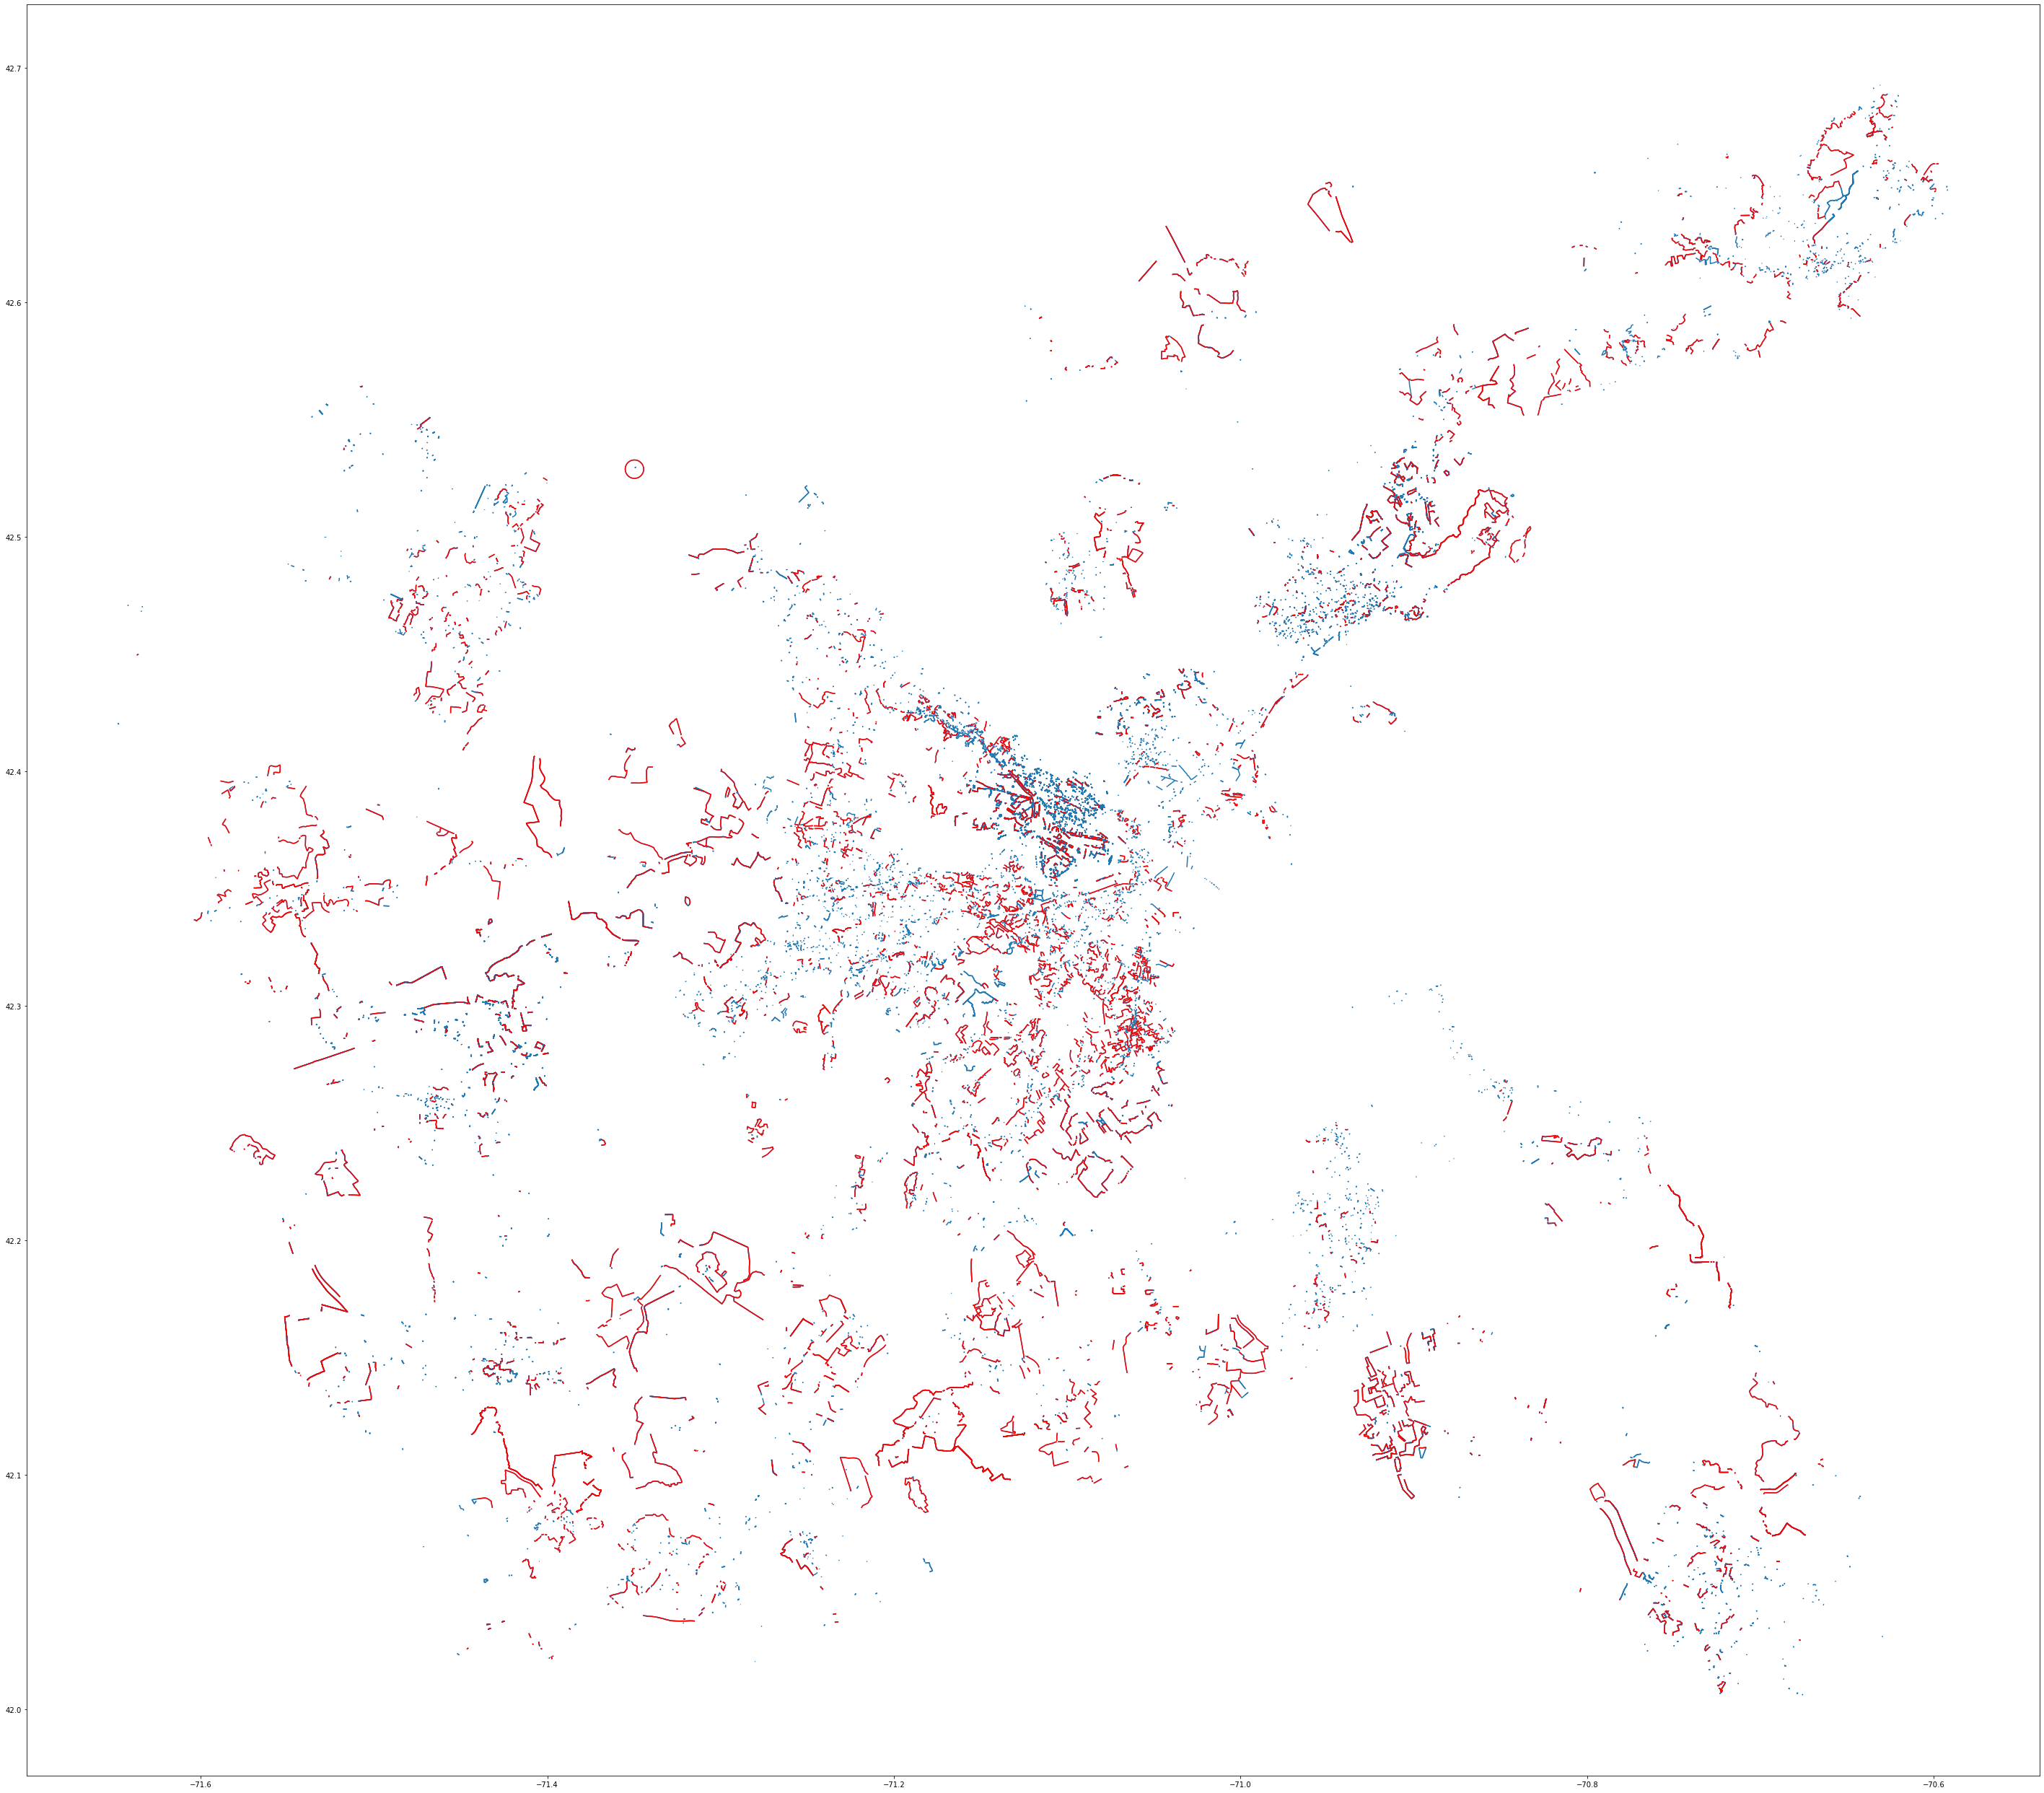

In [41]:
# ploting the original boundaries on to of straight lines

# boundary_gdf.to_crs("EPSG:4269", inplace = True)
# base = boundary_gdf.plot(figsize=(50,50))
# export_gdf.plot(ax = base, color="red")